In [1402]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt


import os
import re


os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the ODE

$$\frac{du}{dt} - cos(2\pi t)=0$$

with solution 
$$ u(t) = \frac{sin ( 2 \pi t )}{2 \pi} + 1$$

## The Inverse parametric equation will be 

$$\frac{du}{dt} - \alpha cos( 2 \pi t)=0$$

Text(0, 0.5, 'Observations')

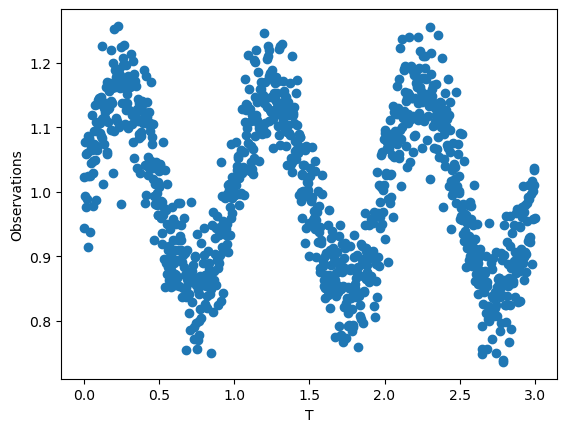

In [1403]:
t= np.linspace(0,3,1000)
mean, std = 0,0.05

Exact = (1/ (2*np.pi))*np.sin(2*np.pi*t)+1

noise_sol = Exact + np.random.normal(mean,std, len(t))

plt.scatter(t,noise_sol)
plt.xlabel("T")
plt.ylabel("Observations")


## Feed Forward Neural Network

In [1404]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## PINN for Inverse Problems

In [1405]:
def register_parameters(self,alpha,alpha_name):

    for param,name in zip(alpha, alpha_name):
        _param = torch.nn.Parameter(torch.tensor(param, requires_grad=True).reshape(-1).float().to(device))

        #if re.compile("weight").search(name):
        #    _param = torch.clamp(_param,0,1)
    
        setattr(self, name, _param)
        self.register_parameter(name, getattr(self,name))

def clamp_weights(self,param_names):
    pr = torch.clamp(self.weight_eps,0,1).to(device)
    self.weight_eps = torch.nn.Parameter(pr).to(device)
    #for pnames in param_names:
    #    if hasattr(self, pnames):
    #        pr = torch.clamp(getattr(self,pnames),0,1)
    #        setattr(self, pnames,pr)        
        

def PINN(self,t):
    """ The pytorch autograd version of calculating residual """
    u = self(t)
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = u_t - self.alpha*torch.cos( 2*torch.pi *t)
    return f

In [1406]:
DNN.register_parameters = register_parameters
#DNN.clamp_weights = clamp_weights
DNN.PINN = PINN
weight_eps = 0.3

In [1407]:
def train(pinn, loss, optimizer,data_loader,epochs, weighting = False):
  pinn.train()

  print("Starting Training")

  for epoch in range(epochs):
    itr_loss = 0.0   

    for _,(X,y) in enumerate(data_loader):
      iter = 0

      X, y = Variable(X, requires_grad=True), Variable(y)

      def loss_func_train():

        optimizer.zero_grad()

        u_pred,f_pred = pinn(X),pinn.PINN(X)

        loss_u,loss_f = loss(u_pred,y),loss(f_pred,torch.zeros_like(y))

        if weighting:
          Loss = weight_eps * loss_u + (1 - weight_eps) * loss_f
        else:
          Loss = loss_u + loss_f
          
        Loss.backward() 
        
        #with torch.no_grad():
        #torch.nn.utils.clip_grad
        #  pinn.weight_eps.clamp_(0, 1)


        if iter % 100 == 0:
          if weighting:
              print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e, Alpha:%.3f' % (iter, Loss.item(), loss_u.item(), loss_f.item(),
                                                                                           pinn.alpha.item())
                  )
          else:
              print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e, Alpha:%.3f' % (iter, Loss.item(), loss_u.item(), loss_f.item(),pinn.alpha.item())
                  )
          
        return Loss

      optimizer.step(loss_func_train) 

      iter += 1
     
      oupt = pinn(X)  

      loss_val = loss_func_train() 

      itr_loss += loss_val.item()  

    print("iteration = %4d   loss = %0.4f" % (epoch + 1, itr_loss))


In [1408]:
# Number of observations
nobs = 500
lr = 0.1
epochs = 10

layers = [1]+2*[12] +[1]

data_training = np.hstack((t.flatten()[:,None], noise_sol.flatten()[:,None]))

idx = np.random.choice(data_training.shape[0], nobs, replace=False)

X_u_train = torch.from_numpy(data_training[idx, :]).float().to(device)

x,y = X_u_train[:,0:1].reshape(-1,1),X_u_train[:,1:2].reshape(-1,1)

X_u_train = TensorDataset(x,y)
X_u_train = DataLoader(X_u_train,batch_size=100)

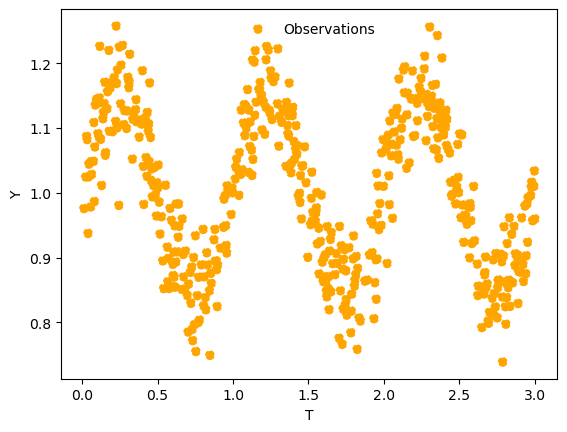

In [1409]:
plt.scatter(x,y,linestyle='dashed', label = "Observations",color= "orange")

plt.xlabel("T")
plt.ylabel("Y")
plt.legend(frameon=False)

In [1410]:
model = DNN(layers)
#model.register_parameters(np.array([0.5,0.5]),np.array(["alpha","weight_eps"]))
model.register_parameters(np.array([0.5]),np.array(["alpha"]))
#model.clamp_weights("weight_eps")

In [1411]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

In [1412]:
train(model, loss, optimizer,X_u_train,epochs,True)

Starting Training
Iter 0, Loss: 3.84739e-01, Loss_u: 9.87142e-01, Loss_f: 1.26566e-01, Alpha:0.500
Iter 0, Loss: 3.70475e-01, Loss_u: 9.44101e-01, Loss_f: 1.24635e-01, Alpha:0.496
Iter 0, Loss: 2.56339e-01, Loss_u: 6.00823e-01, Loss_f: 1.08702e-01, Alpha:0.464
Iter 0, Loss: 2.10075e-01, Loss_u: 4.71446e-01, Loss_f: 9.80593e-02, Alpha:0.440
Iter 0, Loss: 4.24552e-02, Loss_u: 2.84933e-02, Loss_f: 4.84389e-02, Alpha:0.271
Iter 0, Loss: 4.04658e-02, Loss_u: 2.82073e-02, Loss_f: 4.57195e-02, Alpha:0.262
Iter 0, Loss: 2.53554e-02, Loss_u: 2.57929e-02, Loss_f: 2.51680e-02, Alpha:0.181
Iter 0, Loss: 2.19179e-02, Loss_u: 2.46750e-02, Loss_f: 2.07363e-02, Alpha:0.162
Iter 0, Loss: 6.34177e-03, Loss_u: 1.82471e-02, Loss_f: 1.23951e-03, Alpha:-0.010
Iter 0, Loss: 6.22187e-03, Loss_u: 1.80474e-02, Loss_f: 1.15379e-03, Alpha:-0.010
Iter 0, Loss: 5.47202e-03, Loss_u: 1.66938e-02, Loss_f: 6.62707e-04, Alpha:-0.012
Iter 0, Loss: 5.41092e-03, Loss_u: 1.66098e-02, Loss_f: 6.11379e-04, Alpha:-0.011
Iter 0

In [1413]:
from laplace import Laplace
from laplace.utils import ParamNameSubnetMask

subnetwork_mask = ParamNameSubnetMask(model, parameter_names=['alpha','layers.layer_2.weight','layers.layer_2.bias'])
subnetwork_mask.select()
subnetwork_indices = subnetwork_mask.indices

#la = Laplace(model, 'regression', subset_of_weights='subnetwork', hessian_structure='full',subnetwork_indices=subnetwork_indices)

la = Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='diag')

la.fit(X_u_train)

In [1414]:
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)

hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [1415]:
torch.nn.utils.parameters_to_vector(la.model.last_layer.parameters())

tensor([ 0.9153, -2.3555, -1.2691,  0.2813, -1.4095,  0.7607,  2.0017, -0.4619,
        -0.2395,  0.0563,  1.0031, -4.9743, -1.7364], grad_fn=<CatBackward0>)

In [1416]:
la.mean

tensor([ 0.9153, -2.3555, -1.2691,  0.2813, -1.4095,  0.7607,  2.0017, -0.4619,
        -0.2395,  0.0563,  1.0031, -4.9743, -1.7364])

In [1417]:
la.posterior_precision

tensor([197649.3281,  87803.1172, 207069.8906, 207067.1406, 206832.8438,
        207070.2031, 206781.8594, 204249.7656, 182902.3125, 205001.2344,
         53386.6328, 102508.9453, 207071.7812], grad_fn=<AddBackward0>)

In [1418]:
t= np.linspace(0,4,500)

sol = (1/ (2*np.pi))*np.sin(2*np.pi*t)+1

noise_sol_test = sol + np.random.normal(mean,std, len(t))

In [1419]:
f_mu, f_var = la(torch.tensor(t.flatten()[:,None]).float())
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)


In [1420]:

u_pred = model(torch.tensor(t.flatten()[:,None] ).float()).detach().cpu().numpy()

error_u = np.linalg.norm(noise_sol_test-u_pred,2)/np.linalg.norm(noise_sol_test,2)
print('Error u: %e' % (error_u)) 

Error u: 4.524570e+00


In [1421]:
#for name, param in la.model.named_parameters():
#        print(name, param.data)

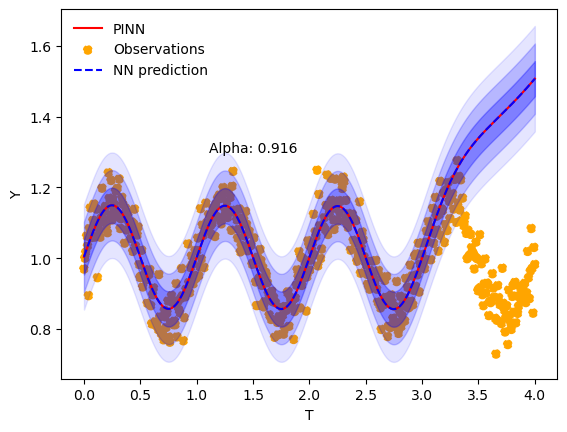

In [1422]:
plt.plot(t, u_pred, label = "PINN", color = "red")


plt.scatter(t,noise_sol_test,linestyle='dashed', label = "Observations",color= "orange")
plt.annotate(f"Alpha: {model.alpha.item():0.3f}",(1.5,1.3),ha='center')


plt.plot(t, f_mu, "--",label='NN prediction',color="blue")
plt.fill_between(t, f_mu+pred_std,f_mu-pred_std,alpha=0.3, color = "blue")
plt.fill_between(t, f_mu+2*pred_std,f_mu-2*pred_std,alpha=0.2, color = "blue")
plt.fill_between(t, f_mu+3*pred_std,f_mu-3*pred_std,alpha=0.1, color = "blue")


plt.xlabel("T")
plt.ylabel("Y")
plt.legend(frameon=False)

In [ ]:
from LaplacePINN import Laplace
from laplace.utils import ParamNameSubnetMask

#subnetwork_mask = ParamNameSubnetMask(model, parameter_names=['alpha','layers.layer_2.weight','layers.layer_2.bias'])
subnetwork_mask = ParamNameSubnetMask(model, parameter_names=['layers.layer_2.weight','layers.layer_2.bias'])
subnetwork_mask.select()
subnetwork_indices = subnetwork_mask.indices

In [ ]:
from backpack.extensions import DiagGGNExact, DiagGGNMC, KFAC, KFLR, SumGradSquared, BatchGrad
from backpack import backpack, extend, memory_cleanup
from torch.nn.utils import parameters_to_vector, vector_to_parameters


# def diag(self, X, y, **kwargs):
#     context = DiagGGNMC if self.stochastic else DiagGGNExact
#     f = self.model(X)
#     loss = self.lossfunc(f, y)
#     with backpack(context()):
#         loss.backward()
#     dggn = self._get_diag_ggn()

# def _get_diag_ggn(self):
#         if self.stochastic:
#             return torch.cat([p.diag_ggn_mc.data.flatten() for p in self._model.parameters()])
#         else:
#             return torch.cat([p.diag_ggn_exact.data.flatten() for p in self._model.parameters()])

_model = extend(model,use_converter=True)

_loss = extend(torch.nn.MSELoss(reduction ='mean'))


XX,yy = next(iter(X_u_train))

XX, yy = Variable(XX, requires_grad=True), Variable(yy, requires_grad=True)

_model.zero_grad()

_model.eval()

uu = _model(XX)

lloss = _loss(uu, yy) 

with backpack(DiagGGNExact()):
       lloss.backward()

h = torch.cat([p.diag_ggn_exact.data.flatten() for p in _model.parameters()])
print(h)
print(h.shape)

len(parameters_to_vector(_model.parameters()))